In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from glob import glob
import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = "../input/masksandlabels/"
IMAGES = '../input/landscape-pictures/'
labels_files = sorted(glob(PATH + "*_label.npy"))
files_masks = sorted(set((glob(PATH + "*.npy"))) - set(labels_files))
files = ([IMAGES+filename.split('/')[-1][:-3]+'jpg' for filename in files_masks])
files = sorted(files)

In [3]:
SPLIT = 0.2

split_index = int(len(files) * (1 - SPLIT))
train_files = files[:split_index]
val_files = files[split_index:]

train_masks = files_masks[:split_index]
val_masks = files_masks[split_index:]

train_labels = labels_files[:split_index]
val_labels = labels_files[split_index:]

print(f"Total samples: {len(files)}.")
print(f"Total training samples: {len(train_files)}.")
print(f"Total validation samples: {len(val_files)}.")

Total samples: 555.
Total training samples: 444.
Total validation samples: 111.


In [4]:
class SPADE(torch.nn.Module):
  def __init__(self, filters, mask_shape, epsilon=1e-5, **kwargs):
    super().__init__(**kwargs) # mask_shape = (NC, H, W)
    self.epsilon = epsilon
    self.mask_shape = mask_shape
    self.conv = torch.nn.Conv2d(mask_shape[0], 128, 3, padding=1) # in_channels, out_channels, kernel_size, stride=1, padding=0,
    self.conv_gamma = torch.nn.Conv2d(128, filters, 3, padding=1)
    self.conv_beta = torch.nn.Conv2d(128, filters, 3, padding=1)
  def forward(self, input_tensor, raw_mask):
    # raw mask has shape (B, NC, H, W)
    mask = torchvision.transforms.functional.resize(raw_mask, input_tensor.shape[2:4], torchvision.transforms.InterpolationMode.NEAREST)
    x = self.conv(mask)
    gamma = self.conv_gamma(x)
    beta = self.conv_beta(x)
    mean = torch.mean(input_tensor, axis=(0,2,3), keepdim=True)
    var = torch.var(input_tensor, axis=(0,2,3), keepdim=True)
    std = torch.sqrt(var+self.epsilon)
    normalized = (input_tensor-mean) / std
    output = gamma * normalized + beta
    return output

In [5]:
class ResBlock(nn.Module):
  def __init__(self, filters, input_shape, mask_shape, **kwargs):
    super().__init__(**kwargs) # input shape = (C,H,W), mask_shape = (C,H,W), filters - channels in input_tensor?
    self.filters = filters
    self.mask_shape = mask_shape
    self.input_shape = input_shape
    self.spade_1 = SPADE(input_shape[0], mask_shape) # num channels
    self.spade_2 = SPADE(filters, mask_shape)
    self.conv_1 = nn.Conv2d(input_shape[0], filters, 3, padding=1)
    self.conv_2 = nn.Conv2d(filters, filters, 3, padding=1)
    self.learned_skip = False
    if filters != input_shape[0]:
      self.learned_skip = True
      self.spade_3 = SPADE(input_shape[0], mask_shape)
      self.conv_3 = nn.Conv2d(input_shape[0], filters, 3, padding=1)
  def forward(self, input_tensor, mask):
    
    x = self.spade_1(input_tensor, mask)
    x = self.conv_1(F.leaky_relu(x, 0.2))

    x = self.spade_2(x, mask)
    x = self.conv_2(F.leaky_relu(x, 0.2))

    skip = (
            self.conv_3(F.leaky_relu(self.spade_3(input_tensor, mask), 0.2))
            if self.learned_skip
            else input_tensor
        )
    output = skip + x
    return output

In [6]:
class GaussianSampler(nn.Module):
  def __init__(self, batch_size, latent_dim, **kwargs):
    super().__init__(**kwargs)
    self.batch_size = batch_size
    self.latent_dim = latent_dim
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
  def forward(self, means, variance):
    epsilon = torch.normal(0,1.0, size=(means.shape[0], self.latent_dim)).to(self.device)
    samples = means + torch.exp(0.5 * variance) * epsilon
    return samples

In [7]:
class Downsampler(nn.Module):
  def __init__(self, in_channels, channels, kernels, strides=2, apply_norm=True, apply_activation=True, apply_dropout=False):
    super().__init__()
    blocks = [
              nn.Conv2d(
                in_channels,
                channels,
                kernels,
                stride=strides,
                padding=(kernels-1)//2, # same mode
                bias=False
            )
    ]
    nn.init.xavier_normal_(blocks[0].weight)
    if apply_norm:
        blocks.append(nn.InstanceNorm2d(channels))
    if apply_activation:
        blocks.append(nn.LeakyReLU(0.2))
    if apply_dropout:
        blocks.append(nn.Dropout(0.5))
    self.block = nn.Sequential(*blocks)
  def forward(self, x):
    return self.block(x)

In [8]:
class Encoder(nn.Module):
  def __init__(self, image_shape, encoder_downsample_factor=64, latent_dim=256):
    super().__init__()
    in_channels = image_shape[0]
    h, w = image_shape[1:]
    self.ds1 = Downsampler(in_channels, encoder_downsample_factor, 3, apply_norm=False) # H_out = floor((H-1)/stride + 1, W as above)
    h = int((h-1)/(2.0) +1)
    w = int((w-1)/(2.0) +1)
    self.ds2 = Downsampler(encoder_downsample_factor, 2*encoder_downsample_factor, 3)
    h = int((h-1)/(2.0) +1)
    w = int((w-1)/(2.0) +1)
    self.ds3 = Downsampler(2*encoder_downsample_factor, 4*encoder_downsample_factor, 3)
    h = int((h-1)/(2.0) +1)
    w = int((w-1)/(2.0) +1)
    self.ds4 = Downsampler(4*encoder_downsample_factor, 8*encoder_downsample_factor, 3)
    h = int((h-1)/(2.0) +1)
    w = int((w-1)/(2.0) +1)
    self.ds5 = Downsampler(8*encoder_downsample_factor, 8*encoder_downsample_factor, 3) # results (B, 8*encoder_downsample_factor, H, W)
    h = int((h-1)/(2.0) +1)
    w = int((w-1)/(2.0) +1)
    self.flattener = nn.Flatten() # 8*encoder_downsample_factor shannels

    self.mean_fc = nn.Linear(h*w*8*encoder_downsample_factor, latent_dim)
    self.var_fc = nn.Linear(h*w*8*encoder_downsample_factor, latent_dim)

  def forward(self, x):
    reduced = self.ds5(self.ds4(self.ds3(self.ds2(self.ds1(x)))))
    flattened = self.flattener(reduced)
    mean = self.mean_fc(flattened)
    var = self.var_fc(flattened)
    return mean, var

In [9]:
class Generator(nn.Module):
  def __init__(self, mask_shape, latent_dim=256):
    super().__init__()
    self.latent = latent_dim
    self.mask_shape = mask_shape

    self.linear1 = nn.Linear(latent_dim, 16384)
    self.res1 = ResBlock(1024, (1024,4,4), mask_shape) # gets (linear1 reshaped to (-1,1024,4,4) , mask)
    
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2)
    self.res2 = ResBlock(1024, (1024,8,8), mask_shape) # gets same but image is 2 times larger

    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)
    self.res3 = ResBlock(1024, (1024,16,16), mask_shape) # gets same but image is 2 times larger

    self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2)
    self.res4 = ResBlock(512, (1024,32,32), mask_shape) # gets same but image is 2 times larger -> (B, 512, 32,32)

    self.upsample4 = nn.UpsamplingNearest2d(scale_factor=2)
    self.res5 = ResBlock(256, (512,64,64), mask_shape)

    self.upsample5 = nn.UpsamplingNearest2d(scale_factor=2)
    self.res6 = ResBlock(128, (256,128,128), mask_shape)

    self.upsample6 = nn.UpsamplingNearest2d(scale_factor=2)
    self.leaky_relu = nn.LeakyReLU(0.2)

    self.conv = nn.Conv2d(128, 3, kernel_size=4, padding=0) # input = (B, 128, 256, 256)
    # used F.pad(X, (0, 3, 2, 1)) for "same" padding!
    self.th = nn.Tanh()
  def forward(self, input_tensor, mask):
    
    x = self.linear1(input_tensor)
    x = x.view(-1,1024,4,4)
    x = self.res1(x, mask)

    x = self.upsample1(x)
    x = self.res2(x, mask)
    
    x = self.upsample2(x)
    x = self.res3(x, mask)
    
    x = self.upsample3(x)
    x = self.res4(x, mask)
    
    x = self.upsample4(x)
    x = self.res5(x, mask)
    
    x = self.upsample5(x)
    x = self.res6(x, mask)
    
    x = self.upsample6(x)
    x = self.leaky_relu(x)
    x = self.conv(F.pad(x, (0, 3, 2, 1)))
    x = self.th(x) # this is output image
    
    return x

In [10]:
class Discriminator(nn.Module):
  def __init__(self, image_shape, downsample_factor=64):
    super().__init__()
    self.image_shape = image_shape
    self.downsample_factor = downsample_factor
    self.downsampling1 = Downsampler(2*image_shape[0], downsample_factor, 4, apply_norm=False)
    self.downsampling2 = Downsampler(downsample_factor, 2*downsample_factor, 4)
    self.downsampling3 = Downsampler(2*downsample_factor, 4*downsample_factor, 4)
    self.downsampling4 = Downsampler(4*downsample_factor, 8*downsample_factor, 4, strides=1)
    self.conv = nn.Conv2d(8*downsample_factor,1,4)

  def forward(self, image_A, image_B):
    x = torch.cat([image_A, image_B],dim=1) # Channels stack
    x1 = self.downsampling1(x)
    x2 = self.downsampling2(x1)
    x3 = self.downsampling3(x2)
    x4 = self.downsampling4(x3)
    x5 = self.conv(x4)
    return (x1, x2, x3, x4,x5)

In [11]:
def generator_loss(y):
  return - torch.mean(y)

def kl_divergence_loss(mean, variance):
    return -0.5 * torch.sum(1 + variance - torch.square(mean) - torch.exp(variance))

class FeatureMatchingLoss(nn.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.mae = nn.L1Loss(reduction='mean')
  def forward(self, y_true, y_pred):
    loss = 0
    for i in range(len(y_true) - 1):
        loss += self.mae(y_true[i], y_pred[i])
    return loss

class VGG19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained_features = torchvision.models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)
        h_relu3 = self.slice3(h_relu2)
        h_relu4 = self.slice4(h_relu3)
        h_relu5 = self.slice5(h_relu4)
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out


class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.vgg = VGG19().to(device)
        self.criterion = nn.L1Loss()
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]
        self.preprocessing = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(self.preprocessing(127.5 * (x + 1))), self.vgg(self.preprocessing(127.5 * (y+1))) # + preprocessing?
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i])
        return loss


class MyHingeLoss(nn.Module):

    def __init__(self):
        super(MyHingeLoss, self).__init__()

    def forward(self, output, target):

        hinge_loss = 1 - torch.mul(output, target)
        hinge_loss[hinge_loss < 0] = 0
        return hinge_loss.mean() # mean reduce ?


class DiscriminatorLoss(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hinge_loss = MyHingeLoss() #loss = maximum(1 - y_true * y_pred, 0)`

    def forward(self, y, is_real):
        label = 1.0 if is_real else -1.0
        return self.hinge_loss(label, y)

In [12]:
from itertools import chain
class GauGAN(nn.Module):
  def __init__(self, image_size, num_classes, batch_size, latent_dim, feature_loss_coeff=10, vgg_feature_loss_coeff=0.1,
        kl_divergence_loss_coeff=0.1, gen_lr=1e-4, disc_lr=4e-4,
        **kwargs):
    super().__init__(**kwargs)
    self.image_size = image_size # squared images assumed
    self.latent_dim = latent_dim
    self.num_classes = num_classes
    self.image_shape = (3, image_size, image_size)
    self.mask_shape = (num_classes, image_size, image_size)
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.batch_size = batch_size
    self.feature_loss_coeff = feature_loss_coeff
    self.vgg_feature_loss_coeff = vgg_feature_loss_coeff
    self.kl_divergence_loss_coeff = kl_divergence_loss_coeff

    self.discriminator = Discriminator(self.image_shape).to(self.device) # image_shape, downsample_factor=64
    self.generator = Generator(self.mask_shape).to(self.device)  # mask_shape, latent_dim=256
    self.encoder = Encoder(self.image_shape).to(self.device) # image_shape, encoder_downsample_factor=64, latent_dim=256
    self.sampler = GaussianSampler(batch_size, latent_dim).to(self.device) # batch_size, latent_dim,
    #self.patch_size, self.combined_model = self.build_combined_generator()

    self.generator_optimizer = torch.optim.Adam(
        chain(self.generator.parameters(), self.encoder.parameters())
        ,lr=gen_lr, betas=(0.0, 0.999)
    )
    self.discriminator_optimizer = torch.optim.Adam(
        self.discriminator.parameters()
        ,lr=disc_lr, betas=(0.0, 0.999)
    )
    self.discriminator_loss = DiscriminatorLoss()
    self.feature_matching_loss = FeatureMatchingLoss()
    self.vgg_loss = VGGLoss()
    self.disc_loss_tracker = []
    self.gen_loss_tracker = []
    self.feat_loss_tracker = []
    self.vgg_loss_tracker = []
    self.kl_loss_tracker = []

  def generate(self, latent_input, semantic_labels_input, semantic_map_input):

    #self.discriminator.eval()
    #for param in self.discriminator.parameters():
    #  param.requires_grad = False #freeze them
    generated_image = self.generator(latent_input, semantic_labels_input)
    # generated_image has gradient
    #with torch.no_grad(): # like freeze params
    self.discriminator.eval() # we need to freeze discriminator, but from gen gradient must flow via disc
    for param in self.discriminator.parameters():
      param.requires_grad = False
    discriminator_output = self.discriminator(semantic_map_input, generated_image)

    for param in self.discriminator.parameters():
      param.requires_grad = True
    self.discriminator.train()
    self.patch_size = discriminator_output[-1].shape[2] # height
    return discriminator_output, generated_image

  @torch.no_grad()
  def forward(self, latent_vectors, labels): # What about gradients?
      return self.generator(latent_vectors, labels)

  def train_discriminator(self, latent_vector, segmentation_map, real_image, labels): # perform backward
      #with torch.no_grad(): # aka freeze generator
      
      fake_images = self.generator(latent_vector, labels)
      
      
      #self.discriminator.trainable = True

      pred_fake = self.discriminator(segmentation_map, fake_images)[-1] # take x5
      pred_real = self.discriminator(segmentation_map, real_image)[-1] # take x5

      loss_fake = self.discriminator_loss(pred_fake, False) 
      loss_real = self.discriminator_loss(pred_real, True)
      total_loss = 0.5 * (loss_fake + loss_real)
      #print(total_loss)
      #print(next(self.generator.parameters()).grad)
      self.discriminator_optimizer.zero_grad() # AFTER!
      total_loss.backward()
      
      self.discriminator_optimizer.step()
      
      

      return total_loss

  def train_generator(self, latent_vector, segmentation_map, labels, image, mean, variance): # perform backward
      # Generator learns through the signal provided by the discriminator. During
      # backpropagation, we only update the generator parameters.
      with torch.no_grad(): # aka freeze descriminator
        self.discriminator.eval()
        real_d_output = self.discriminator(segmentation_map, image)
        self.discriminator.train()
      fake_d_output, fake_image = self.generate(
          latent_vector, labels, segmentation_map
      )

      pred = fake_d_output[-1] # take x5 #NO GRADIENT - FIX IT
      
      g_loss = generator_loss(pred)
      #print(g_loss)
      kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
      vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
      feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
          real_d_output, fake_d_output
      )

      total_loss = g_loss + kl_loss + vgg_loss + feature_loss
      # MAKE SURE THAT ENCODER ALSO UPDATE WEIGHTS THROUGT LATENT_VECTOR!
      self.generator_optimizer.zero_grad()
      total_loss.backward() ### THIS ALSO LEADS TO SET OTHERS GRADIENTS
      self.generator_optimizer.step()
      return total_loss, feature_loss, vgg_loss, kl_loss

  def train_step(self, data):
      # Unpack the data.
      
      segmentation_map, image, labels = data

      # Encode the original images and sample latent variables.
      mean, variance = self.encoder(image) # has backw
      latent_vector = self.sampler(mean, variance) # has backw
      # Train the discriminator, encoder, and the generator.
      discriminator_loss = self.train_discriminator(
          latent_vector.detach(), segmentation_map, image, labels # DONT COLLECT GRADIENT ENCODER?
      )
      (generator_loss, feature_loss, vgg_loss, kl_loss) = self.train_generator(
          latent_vector, segmentation_map, labels, image, mean, variance
      )

      # Report progress.
      #self.disc_loss_tracker.append(discriminator_loss)
      #self.gen_loss_tracker.append(generator_loss)
      #self.feat_loss_tracker.append(feature_loss)
      #self.vgg_loss_tracker.append(vgg_loss)
      #self.kl_loss_tracker.append(kl_loss)
      results = {
          'disc':discriminator_loss.detach().cpu().item(),
          'gen':generator_loss.detach().cpu().item(),
          'feat':feature_loss.detach().cpu().item(),
          'vgg':vgg_loss.detach().cpu().item(),
          'kl':kl_loss.detach().cpu().item()
          }
      return results

  @torch.no_grad()
  def test_step(self, data):
      self.encoder.eval()
      self.generator.eval()
      self.discriminator.eval()

      segmentation_map, image, labels = data

      # Obtain the learned moments of the real image distribution.
      mean, variance = self.encoder(image)

      # Sample a latent from the distribution defined by the learned moments.
      latent_vector = self.sampler(mean, variance)

      # Generate the fake images.
      fake_images = self.generator(latent_vector, labels)

      # Calculate the losses.
      pred_fake = self.discriminator(segmentation_map, fake_images)[-1] # take x5
      pred_real = self.discriminator(segmentation_map, image)[-1] # take x5
      loss_fake = self.discriminator_loss(pred_fake, False)
      loss_real = self.discriminator_loss(pred_real, True)
      total_discriminator_loss = 0.5 * (loss_fake + loss_real)
      real_d_output = self.discriminator(segmentation_map, image)
      fake_d_output, fake_image = self.generate(
          latent_vector, labels, segmentation_map
      )
      pred = fake_d_output[-1] # take x5
      g_loss = generator_loss(pred)
      kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
      vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
      feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
          real_d_output, fake_d_output
      )
      total_generator_loss = g_loss + kl_loss + vgg_loss + feature_loss

      self.encoder.train()
      self.generator.train()
      self.discriminator.train()
      # Report progress.
      #self.disc_loss_tracker.append(total_discriminator_loss)
      #self.gen_loss_tracker.append(total_generator_loss)
      #self.feat_loss_tracker.append(feature_loss)
      #self.vgg_loss_tracker.append(vgg_loss)
      #self.kl_loss_tracker.append(kl_loss)
      results = {
          'disc':total_discriminator_loss.detach().cpu().item(),
          'gen':total_generator_loss.detach().cpu().item(),
          'feat':feature_loss.detach().cpu().item(),
          'vgg':vgg_loss.detach().cpu().item(),
          'kl':kl_loss.detach().cpu().item()
          }
      return results

In [13]:
IMG_HEIGHT = 256
NUM_CLASSES = 9
BATCH_SIZE = 4

In [14]:
class FlickrDataset(Dataset):
  def __init__(self, pathes_image, pathes_mask, pathes_labels, IMG_H=256, IMG_W=256, n_clsses=8, augment=False): # 8?
    self.pathes_image = pathes_image
    self.pathes_mask = pathes_mask
    self.pathes_labels = pathes_labels
    self.h = IMG_H
    self.w = IMG_W
    self.n_clsses = n_clsses
    self.augment = augment
    self.cropper = torchvision.transforms.RandomResizedCrop((256,256), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
    self.affine = torchvision.transforms.RandomAffine(degrees=(-10,10), scale=(1,1.1), shear=(-10,10,-10,10), )
    self.flipper = torchvision.transforms.RandomHorizontalFlip(p=0.5)
  def __getitem__(self, idx):
    image_path = self.pathes_image[idx]
    mask_path = self.pathes_mask[idx]
    label_path = self.pathes_labels[idx]
    image = torchvision.io.read_image(image_path)[:3,:,:] # omit alpha channel
    mask = torch.tensor(np.load(mask_path)).permute(2,0,1)
    label = torch.tensor(np.load(label_path)).permute(2,0,1)
    
    image = (torchvision.transforms.functional.resize(image, (self.h, self.w), torchvision.transforms.InterpolationMode.NEAREST) / 127.5 - 1)#.unsqueeze(0)
    mask = (torchvision.transforms.functional.resize(mask, (self.h, self.w), torchvision.transforms.InterpolationMode.NEAREST) / 127.5 - 1)#.unsqueeze(0)
    label = (torchvision.transforms.functional.resize(label, (self.h, self.w), torchvision.transforms.InterpolationMode.NEAREST))#.unsqueeze(0)
    if torch.rand(1).item() < 0.4 and self.augment:
        composed = torch.cat([mask, image, label], 0)
        composed = self.cropper(composed)
        composed = self.flipper(composed)
        mask, image, label = composed[:3, :, :], composed[3:6, :, :], composed[6:, :, :]
    
    
    if torch.rand(1).item() < 0.4 and self.augment:
        composed = torch.cat([mask, image, label], 0)
        composed = self.affine(composed)
        mask, image, label = composed[:3, :, :], composed[3:6, :, :], composed[6:, :, :]
    return (mask, image, label)
  def __len__(self):
    return len(self.pathes_image)

In [15]:
import cv2
from tqdm import tqdm
colorfull_images = []
for image in tqdm(train_files):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    v_values = np.sum(img[:, :, 2])
    area = img.shape[0] * img.shape[1]

    avg_brightness = v_values/area
    if avg_brightness < 110 or np.median((img.ravel())) < 30.0: # 130 better -> 258
        continue
    colorfull_images.append(image)

100%|██████████| 444/444 [00:14<00:00, 29.78it/s]


In [16]:
len(colorfull_images)

372

In [17]:
train_files_ = colorfull_images
train_masks_ = [PATH + file.split('/')[-1][:-4]+ '.npy' for file in colorfull_images]
train_labels_ = [PATH+file.split('/')[-1][:-4]+'_label.npy' for file in colorfull_images]

In [18]:
train_ds = FlickrDataset(sorted(train_files_), sorted(train_masks_), sorted(train_labels_), augment=True)
val_ds = FlickrDataset(val_files, val_masks, val_labels)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

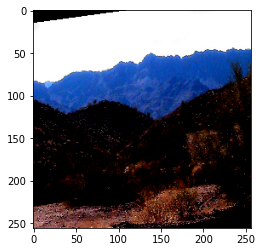

In [19]:
plt.imshow(train_ds[0][1].permute(1,2,0))

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
gaugan = GauGAN(IMG_HEIGHT, NUM_CLASSES, BATCH_SIZE, latent_dim=256)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [22]:
from tqdm import tqdm
def train_epoch(gan, dataset_train):
  train_report = {
      'disc' : [],
      'gen': [],
      'feat': [],
      'vgg':[],
      'kl': []
  }
  gan.train()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  for data_piece in (dataset_train):
    report = gan.train_step((data_piece[0].to(device),data_piece[1].to(device),data_piece[2].to(device)))
    for key, value in report.items():
      train_report[key].append(value)
  return train_report

@torch.no_grad()
def evaluate_epoch(gan, val_dataset):
  eval_report = {
        'disc' : [],
        'gen': [],
        'feat': [],
        'vgg':[],
        'kl': []
    }
  gan.eval()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  for data_piece in (val_dataset):
    report = gan.test_step((data_piece[0].to(device),data_piece[1].to(device),data_piece[2].to(device)))
    for key, value in report.items():
      eval_report[key].append(value)
  gan.train()
  return eval_report

def trainer(gan, epochs, dataset_train, dataset_val, save_step=10):
  train_history = {
      'disc' : [],
      'gen': [],
      'feat': [],
      'vgg':[],
      'kl': []
  }
  val_history = {
      'disc' : [],
      'gen': [],
      'feat': [],
      'vgg':[],
      'kl': []
  }
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  for epoch in tqdm(range(epochs)):
    train_report = train_epoch(gan, dataset_train)
    report_str = ''
    for key, value in train_report.items():
      train_history[key].append(np.mean(value))
      report_str += str(key)+' '+str(np.mean(value))
    print(f"Epoch {epoch+1}, Train : {report_str}")
    if epoch > 0 and (epoch % save_step == 0):
        torch.save(gaugan.state_dict(), f'gaugan{epoch}')
    if epoch%5 == 0: # every 5 epochs
      val_report = evaluate_epoch(gan, dataset_val)
      report_str = ''
      for key, value in val_report.items():
        val_history[key].append(np.mean(value))
        report_str += str(key)+' '+str(np.mean(value))
      print(f"Epoch {epoch+1}, Validation : {report_str}")
      val_images = next(iter(val_loader))
      latent_vector = torch.normal(
          mean=0.0, std=2.0, size=(gan.batch_size, gan.latent_dim),
      )
      # Generate fake images.
      fake_images = gan(latent_vector.to(device), val_images[2].to(device))
      real_images = val_images
      grid_row = min(fake_images.shape[0], 3)
      grid_col = 3
      f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col * 6, grid_row * 6))

      for row in range(grid_row):
          ax = axarr if grid_row == 1 else axarr[row]
          ax[0].imshow((real_images[0][row].permute(1,2,0) + 1) / 2)
          ax[0].axis("off")
          ax[0].set_title("Mask", fontsize=20)
          ax[1].imshow((real_images[1][row].permute(1,2,0) + 1) / 2)
          ax[1].axis("off")
          ax[1].set_title("Ground Truth", fontsize=20)
          ax[2].imshow((fake_images[row].permute(1,2,0).cpu() + 1) / 2)
          ax[2].axis("off")
          ax[2].set_title("Generated", fontsize=20)

      plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1, Train : disc 0.8261602671556575gen 49.2026856125042feat 13.39409847669704vgg 14.308780957293767kl 20.95628846076227
Epoch 1, Validation : disc 0.945087764944349gen 47.625469480242046feat 11.458189010620117vgg 14.412563017436437kl 19.90562186922346


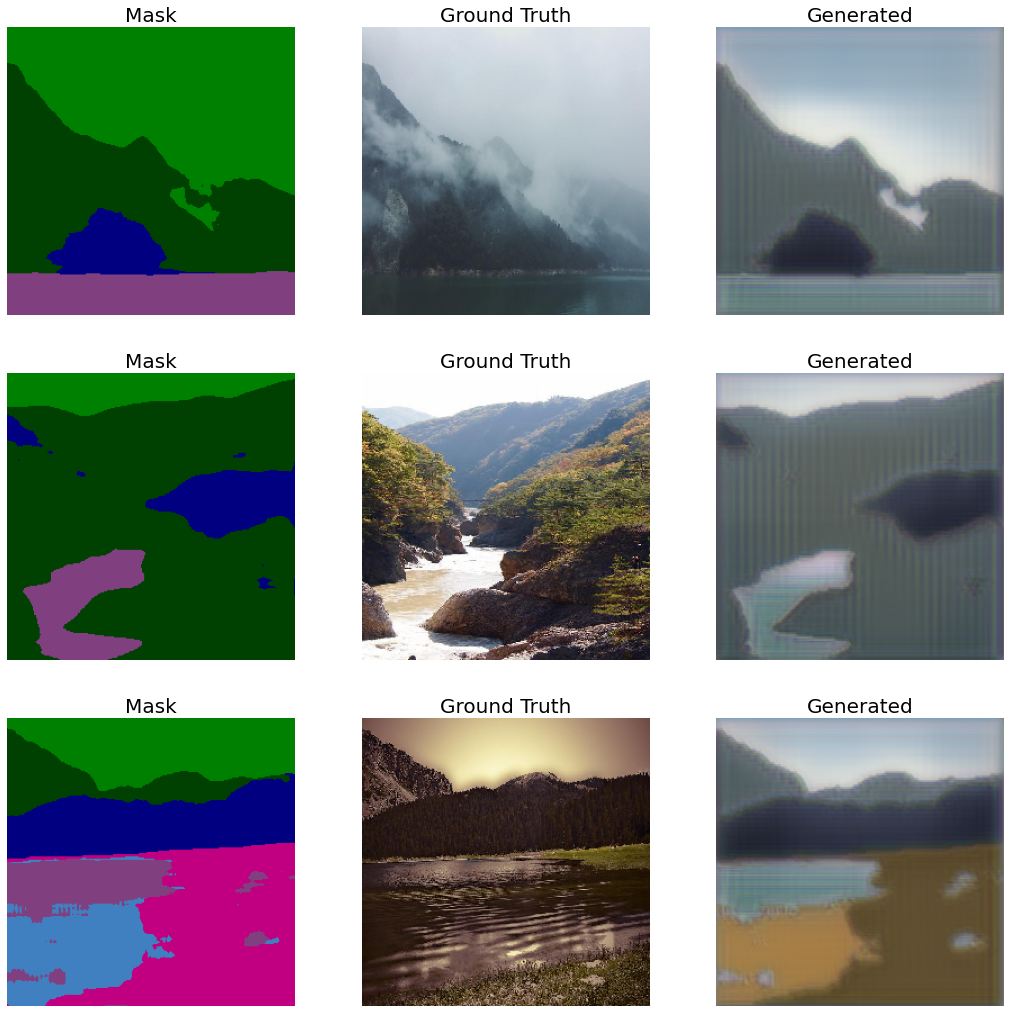

 13%|█▎        | 2/15 [05:11<32:52, 151.73s/it]

Epoch 2, Train : disc 0.6196303345182891gen 47.97257663357642feat 13.63707225553451vgg 13.9634887121057kl 19.430437395649573


 20%|██        | 3/15 [07:02<26:36, 133.07s/it]

Epoch 3, Train : disc 0.5405921603563011gen 42.054590327765354feat 13.584638513544554vgg 13.901118011884792kl 13.500911697264641


 27%|██▋       | 4/15 [08:43<22:05, 120.53s/it]

Epoch 4, Train : disc 0.4447057256975802gen 39.46147020401493feat 13.0647826246036vgg 13.714846313640635kl 11.472088757381645


 33%|███▎      | 5/15 [10:24<18:53, 113.34s/it]

Epoch 5, Train : disc 0.43946053115751155gen 37.64831163549936feat 13.346092459976033vgg 13.703923409984958kl 9.388689412865588
Epoch 6, Train : disc 0.4015024984155291gen 57.88117103166478feat 12.999625636685279vgg 13.583942967076455kl 29.98518176745343
Epoch 6, Validation : disc 0.5553809862051692gen 41.892717770167756feat 12.95802903175354vgg 13.877967017037529kl 14.804630603109088


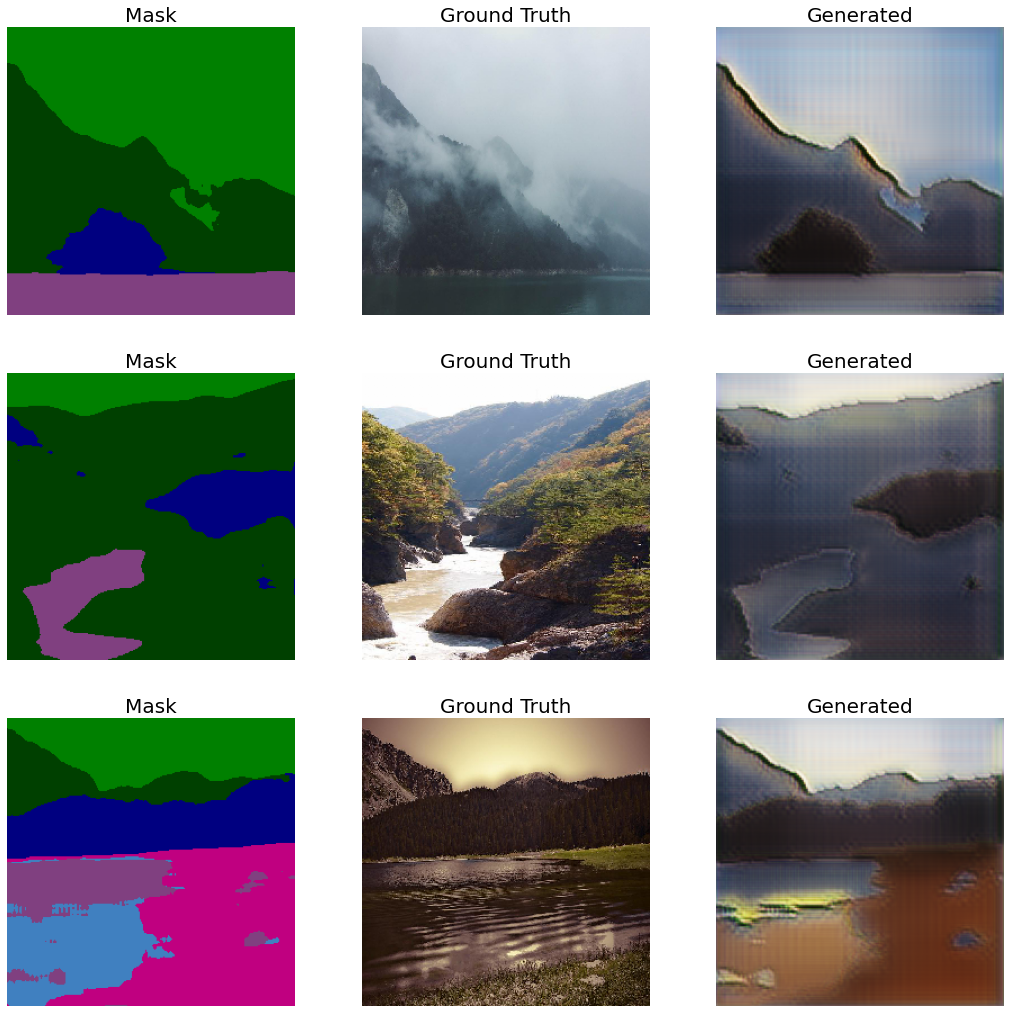

 47%|████▋     | 7/15 [14:14<15:05, 113.16s/it]

Epoch 7, Train : disc 0.39941073303180996gen 38.2080085508285feat 12.806825924945134vgg 13.470975229817052kl 10.638002187974992


 53%|█████▎    | 8/15 [15:56<12:47, 109.62s/it]

Epoch 8, Train : disc 0.385202134929357gen 35.286064024894465feat 12.864514104781613vgg 13.640419980531098kl 7.476436299662436


 60%|██████    | 9/15 [17:38<10:43, 107.23s/it]

Epoch 9, Train : disc 0.3685964364583494gen 31.942614340013073feat 12.718836158834478vgg 13.311810134559549kl 4.648548795330909


 67%|██████▋   | 10/15 [19:22<08:51, 106.27s/it]

Epoch 10, Train : disc 0.33988962170257364gen 43.15725997186476feat 13.133728909236128vgg 13.364732157799505kl 15.288373501070085
Epoch 11, Train : disc 0.31182949991035525gen 38.17802332806331feat 12.945663452148438vgg 13.370210360455257kl 10.445925361366681
Epoch 11, Validation : disc 0.3195870696966137gen 44.184437479291645feat 12.201211861201696vgg 13.975483315331596kl 17.104425600596837


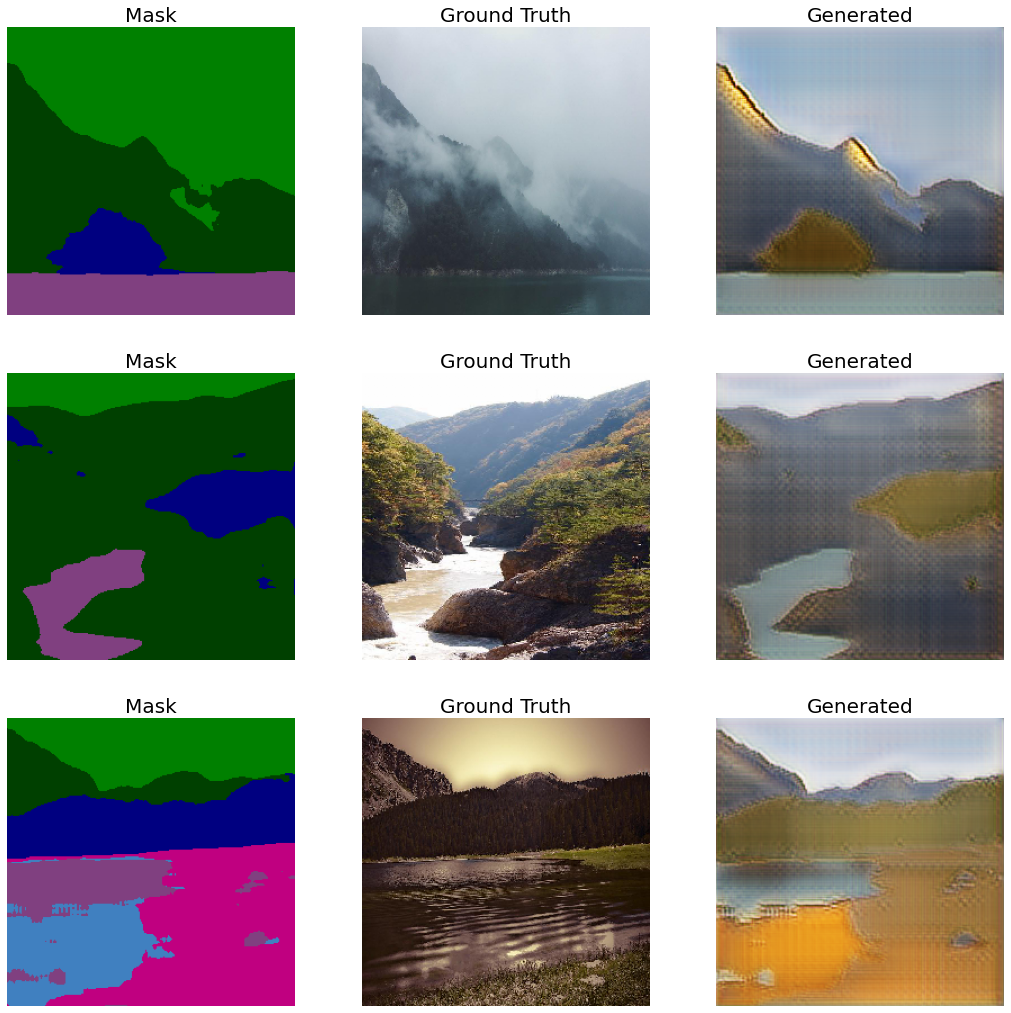

 80%|████████  | 12/15 [23:12<05:29, 109.87s/it]

Epoch 12, Train : disc 0.2937670459079566gen 1109.2814606492238feat 13.155995471503145vgg 13.23498188552036kl 1081.4470143318176


 87%|████████▋ | 13/15 [24:54<03:35, 107.53s/it]

Epoch 13, Train : disc 0.3880681080082732gen 272.0102079658098feat 12.65809578023931vgg 13.254198699869136kl 244.73782397854714


 93%|█████████▎| 14/15 [26:37<01:46, 106.18s/it]

Epoch 14, Train : disc 0.376487162004235gen 278.03226380707116feat 12.71721089270807vgg 13.193889351301296kl 250.76377704579343


100%|██████████| 15/15 [28:20<00:00, 113.35s/it]

Epoch 15, Train : disc 0.38163496397175295gen 148.35038363549018feat 12.717102563509377vgg 13.37376852958433kl 120.88551593083207


In [23]:
trainer(gaugan, 15, train_loader, val_loader, save_step=15)

In [24]:
torch.save(gaugan.state_dict(), 'gaugan') # final